# Weapon Analysis

## Setting Up

In [1]:
import pandas as pd
import calendar

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")
damage_modifiers = pd.read_csv("datasets/damage_modifiers.csv")

## Exploring Data

In [2]:
weapon_stats.head()

,weapon,grip
0,pistol,1
1,rifle,2
2,heavy_cannon,2
3,auto_cannon,2
4,rocket_launcher,2


In [3]:
ammo_stats.head()

,weapon,ammo,damage,damage_type,capacity
0,pistol,pistol_clip,26,armor_piercing,12.0
1,rifle,rifle_clip,30,armor_piercing,20.0
2,heavy_cannon,heavy_cannon_ap,56,armor_piercing,6.0
3,heavy_cannon,heavy_cannon_he,52,high_explosive,6.0
4,heavy_cannon,heavy_cannon_inc,60,incendiary,6.0


In [4]:
weapon_firemodes.head()

,weapon,fire_mode,time_units,accuracy
0,pistol,snapshot,18,60
1,pistol,aimed,30,78
2,rifle,auto,35,35
3,rifle,snapshot,25,60
4,rifle,aimed,80,110


In [5]:
damage_modifiers.head()

,target,armor_piercing,incendiary,high_explosive,laser,plasma,stun,melee,acid_spit
0,terrain,100,100,100,100,100,100,100,100
1,unarmored,100,100,100,100,100,100,120,160
2,personal_armor,100,80,100,100,100,90,100,110
3,power_suit,100,0,100,100,100,80,100,100
4,tank,100,40,75,100,100,100,90,40


## Data Merge

In [6]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks = weapon_attacks.sort_values(by=["weapon", "fire_mode"])
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32


## Chance to Hit

Soldiers start with an Accuracy value between 40 and 70, giving an average of 55.

To get the change of hit this should by applied to the weapon accuracy. Just multiply them as proportions. So an average of 55 to a weapon of Accuracy 90 means 0.55 * 0.9 = 0.495 chance of hit.

In [7]:
weapon_attacks["chance_to_hit"] = weapon_attacks.apply(lambda x: x["accuracy"] / 100 * 0.55, axis=1)
weapon_attacks

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760
14,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,auto,40,32,0.1760
17,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,auto,40,32,0.1760
12,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,snapshot,33,56,0.3080
15,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,snapshot,33,56,0.3080
18,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,snapshot,33,56,0.3080


## Derived Damage

In [8]:
def burst(group):
    burst = 1;
    
    if group["fire_mode"] == "auto":
        burst = 3

    return burst

In [9]:
def max_shots(group):
    shots = 100 / group["time_units"] * group["burst"];
    
    if shots > group["capacity"]:
        # Shoots above capacity. Has to reload
        max_shots = 100 / group["time_units"]
        if(max_shots > 1):
            # Adds cost to reload between shots
            reload_cost = (max_shots - 1) * 15
            # The cost will be averaged to the shot cost
            reload_cost = reload_cost / max_shots
        else:
            reload_cost = 0
        shots = 100 / (group["time_units"] + reload_cost) * group["burst"];

    return shots

In [10]:
# weapon_attacks = weapon_attacks.apply(burst, axis=1)
weapon_attacks["burst"] = weapon_attacks.apply(burst, axis=1)
weapon_attacks["expected_damage"] = weapon_attacks.apply(lambda x: x["damage"] * x["chance_to_hit"], axis=1)
weapon_attacks["clip_damage"] = weapon_attacks.apply(lambda x: x["capacity"] * x["damage"], axis=1)
weapon_attacks["turn_max_shots"] = weapon_attacks.apply(max_shots, axis=1)
weapon_attacks["turns_to_reload"] = weapon_attacks.apply(lambda x: x["capacity"] / x["turn_max_shots"], axis=1)
weapon_attacks["turn_damage_max"] = weapon_attacks.apply(lambda x: x["turn_max_shots"] * x["damage"], axis=1)
weapon_attacks["turn_damage_expected"] = weapon_attacks.apply(lambda x: x["turn_damage_max"] * x["chance_to_hit"], axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,expected_damage,clip_damage,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,32.175,90.0,1.269841,0.787500,114.285714,40.857143
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,18.942,588.0,1.250000,11.200000,52.500000,23.677500
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,19.844,616.0,1.250000,11.200000,55.000000,24.805000
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,21.648,672.0,1.250000,11.200000,60.000000,27.060000
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,7.392,588.0,7.500000,1.866667,315.000000,55.440000


## Weapon Stats

### Average Damage

Ignoring the rate of fire, but choosing the highest values among the fire modes.

In [11]:
average_damage = weapon_attacks[["weapon", "expected_damage"]]
average_damage = average_damage.groupby("weapon").max()
average_damage = average_damage.sort_values(by=["expected_damage"])
average_damage

,expected_damage
weapon,
pistol,11.1540
laser_pistol,17.2040
grenade,17.8750
rifle,18.1500
auto_cannon,21.6480
plasma_pistol,24.3100
proximity_grenade,25.0250
cannon_turret,29.7000
heavy_cannon,29.7000


<AxesSubplot:xlabel='weapon'>

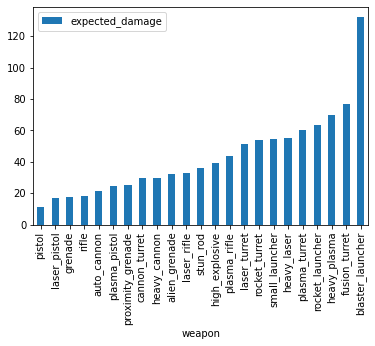

In [12]:
average_damage.plot.bar()

### Shots Per Turn

Supposing all the attacks are done on auto, or the highest rate of fire setting.

In [13]:
shots_per_turn = weapon_attacks[["weapon", "turn_max_shots"]]
shots_per_turn = shots_per_turn.rename(columns={"turn_max_shots": "turn_shots"})
shots_per_turn = shots_per_turn.groupby("weapon").max()
shots_per_turn = shots_per_turn.sort_values(by=["turn_shots"])
shots_per_turn

,turn_shots
weapon,
blaster_launcher,1.204819
alien_grenade,1.269841
grenade,1.269841
high_explosive,1.269841
proximity_grenade,1.269841
fusion_turret,1.515152
rocket_launcher,1.877934
small_launcher,2.040816
rocket_turret,2.222222


<AxesSubplot:xlabel='weapon'>

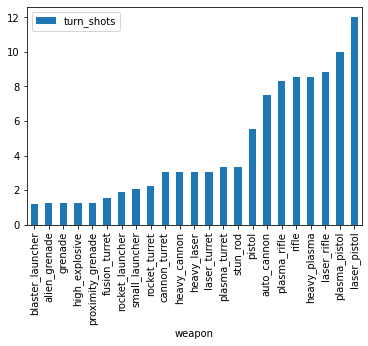

In [14]:
shots_per_turn.plot.bar()

### Ammo

In [15]:
weapon_ammo = weapon_attacks[["weapon", "capacity"]]
weapon_ammo = weapon_ammo.rename(columns={"capacity": "ammo"})
weapon_ammo = weapon_ammo.groupby("weapon").max()
weapon_ammo = weapon_ammo.sort_values(by=["ammo"])
weapon_ammo = weapon_ammo[weapon_ammo["ammo"] < 255]
weapon_ammo

,ammo
weapon,
alien_grenade,1.0
rocket_launcher,1.0
proximity_grenade,1.0
high_explosive,1.0
grenade,1.0
small_launcher,1.0
blaster_launcher,1.0
heavy_cannon,6.0
rocket_turret,8.0


<AxesSubplot:xlabel='weapon'>

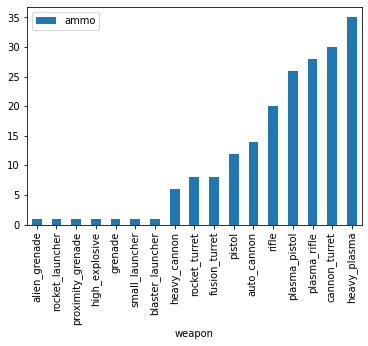

In [16]:
weapon_ammo.plot.bar()

## Damage Ranking

### Most Damaging Weapon

In a single turn, shooting as much as possible, which weapon does the most damage.

This takes into account reloading.

In [17]:
most_damaging_weapon = weapon_attacks[["weapon", "turn_damage_expected"]]
most_damaging_weapon = most_damaging_weapon.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon = most_damaging_weapon.groupby("weapon").max()
most_damaging_weapon = most_damaging_weapon.sort_values(by=["turn_damage"])
most_damaging_weapon

,turn_damage
weapon,
grenade,22.698413
proximity_grenade,31.777778
alien_grenade,40.857143
pistol,47.666667
rifle,49.500000
high_explosive,49.936508
cannon_turret,60.000000
heavy_cannon,60.000000
auto_cannon,63.360000


<AxesSubplot:xlabel='weapon'>

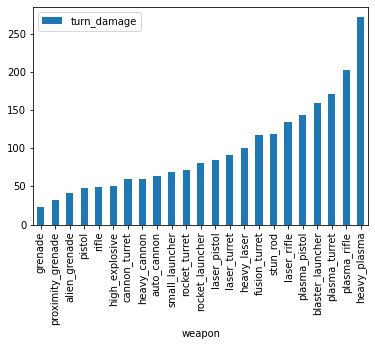

In [18]:
most_damaging_weapon.plot.bar()

### Most Damaging Snapshot

In [19]:
most_damaging_weapon_snap = weapon_attacks[weapon_attacks["fire_mode"] == "snapshot"]
most_damaging_weapon_snap = most_damaging_weapon_snap[["weapon", "turn_damage_expected"]]
most_damaging_weapon_snap = most_damaging_weapon_snap.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_snap = most_damaging_weapon_snap.groupby("weapon").max()
most_damaging_weapon_snap = most_damaging_weapon_snap.sort_values(by=["turn_damage"])
most_damaging_weapon_snap

,turn_damage
weapon,
rifle,39.600000
auto_cannon,44.800000
pistol,47.666667
laser_pistol,50.600000
rocket_launcher,56.807512
rocket_turret,57.138889
cannon_turret,60.000000
heavy_cannon,60.000000
plasma_pistol,61.966667


<AxesSubplot:xlabel='weapon'>

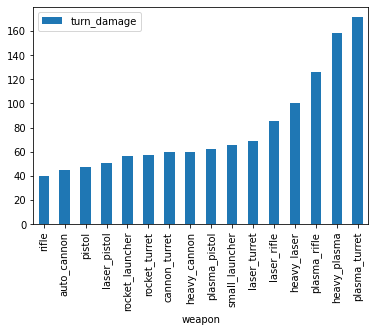

In [20]:
most_damaging_weapon_snap.plot.bar()

### Most Damaging Aimed

In [21]:
most_damaging_weapon_aim = weapon_attacks[weapon_attacks["fire_mode"] == "aimed"]
most_damaging_weapon_aim = most_damaging_weapon_aim[["weapon", "turn_damage_expected"]]
most_damaging_weapon_aim = most_damaging_weapon_aim.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_aim = most_damaging_weapon_aim.groupby("weapon").max()
most_damaging_weapon_aim = most_damaging_weapon_aim.sort_values(by=["turn_damage"])
most_damaging_weapon_aim

,turn_damage
weapon,
rifle,22.687500
auto_cannon,27.060000
laser_pistol,31.280000
cannon_turret,37.125000
heavy_cannon,37.125000
pistol,37.180000
plasma_pistol,40.516667
laser_rifle,66.000000
small_launcher,69.142857


<AxesSubplot:xlabel='weapon'>

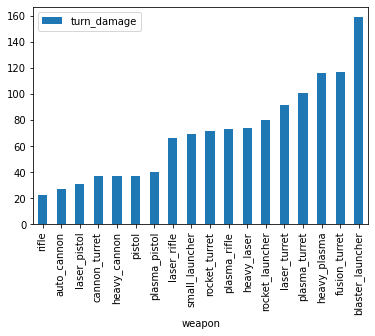

In [22]:
most_damaging_weapon_aim.plot.bar()

### Most Damaging Auto

In [23]:
most_damaging_weapon_auto = weapon_attacks[weapon_attacks["fire_mode"] == "auto"]
most_damaging_weapon_auto = most_damaging_weapon_auto[["weapon", "turn_damage_expected"]]
most_damaging_weapon_auto = most_damaging_weapon_auto.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_auto = most_damaging_weapon_auto.groupby("weapon").max()
most_damaging_weapon_auto = most_damaging_weapon_auto.sort_values(by=["turn_damage"])
most_damaging_weapon_auto

,turn_damage
weapon,
rifle,49.500000
auto_cannon,63.360000
laser_pistol,85.008000
laser_rifle,133.941176
plasma_pistol,143.000000
plasma_rifle,201.666667
heavy_plasma,271.071429


<AxesSubplot:xlabel='weapon'>

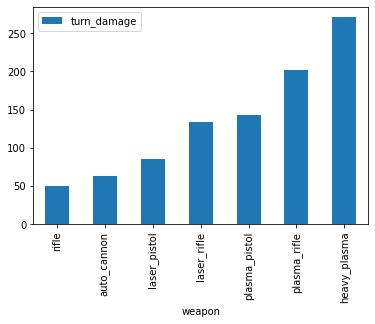

In [24]:
most_damaging_weapon_auto.plot.bar()

### Most Damaging Grenade

In [25]:
most_damaging_weapon_grenade = weapon_attacks[weapon_attacks["fire_mode"] == "grenade"]
most_damaging_weapon_grenade = most_damaging_weapon_grenade[["weapon", "turn_damage_expected"]]
most_damaging_weapon_grenade = most_damaging_weapon_grenade.rename(columns={"turn_damage_expected": "turn_damage"})
most_damaging_weapon_grenade = most_damaging_weapon_grenade.set_index(["weapon"])
most_damaging_weapon_grenade = most_damaging_weapon_grenade.sort_values(by=["turn_damage"])
most_damaging_weapon_grenade

,turn_damage
weapon,
grenade,22.698413
proximity_grenade,31.777778
alien_grenade,40.857143
high_explosive,49.936508


<AxesSubplot:xlabel='weapon'>

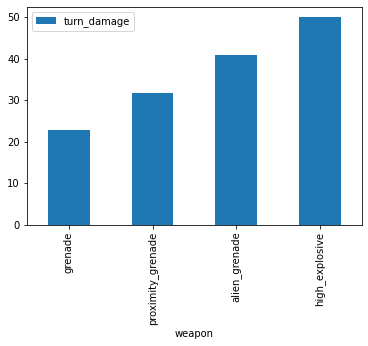

In [26]:
most_damaging_weapon_grenade.plot.bar()

## Damage to Target Type

### Data Merge

In [27]:
weapon_damages = weapon_attacks
weapon_damages = weapon_damages.append([weapon_damages] * (len(damage_modifiers.index)-1),ignore_index=True)
weapon_damages["key"] = weapon_damages.groupby(["weapon", "ammo", "fire_mode"]).cumcount()

targets = damage_modifiers["target"]

weapon_damages = pd.merge(weapon_damages, targets, left_on="key", right_index=True, how="left", sort=False)
weapon_damages = weapon_damages.drop(columns=["key"])
weapon_damages

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,expected_damage,clip_damage,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected,target
0,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,32.1750,90.0,1.269841,0.787500,114.285714,40.857143,terrain
1,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,18.9420,588.0,1.250000,11.200000,52.500000,23.677500,terrain
2,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,19.8440,616.0,1.250000,11.200000,55.000000,24.805000,terrain
3,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,21.6480,672.0,1.250000,11.200000,60.000000,27.060000,terrain
4,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,7.3920,588.0,7.500000,1.866667,315.000000,55.440000,terrain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,aimed,75,115,0.6325,1,53.7625,680.0,1.333333,6.000000,113.333333,71.683333,zombie
836,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,snapshot,45,55,0.3025,1,25.7125,680.0,2.222222,3.600000,188.888889,57.138889,zombie
837,small_launcher,2,stun_bomb,90,stun,1.0,aimed,75,110,0.6050,1,54.4500,90.0,1.269841,0.787500,114.285714,69.142857,zombie
838,small_launcher,2,stun_bomb,90,stun,1.0,snapshot,40,65,0.3575,1,32.1750,90.0,2.040816,0.490000,183.673469,65.663265,zombie


### Damage vs Type

In [28]:
def damage_modifier(group):
    target = damage_modifiers[damage_modifiers["target"] == group["target"]]
    damage = target[group["damage_type"]].values[0]
    return damage / 100

In [29]:
weapon_damages["target_damage"] = weapon_damages.apply(damage_modifier, axis=1)
weapon_damages["target_damage"] = weapon_damages.apply(lambda x: x["damage"] * damage_modifier(x), axis=1)
weapon_damages["target_expected_damage"] = weapon_damages.apply(lambda x: x["expected_damage"] * damage_modifier(x), axis=1)
weapon_damages["target_clip_damage"] = weapon_damages.apply(lambda x: x["clip_damage"] * damage_modifier(x), axis=1)
weapon_damages["target_turn_damage_max"] = weapon_damages.apply(lambda x: x["turn_damage_max"] * damage_modifier(x), axis=1)
weapon_damages["target_turn_damage_expected"] = weapon_damages.apply(lambda x: x["turn_damage_expected"] * damage_modifier(x), axis=1)
weapon_damages

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,...,turn_max_shots,turns_to_reload,turn_damage_max,turn_damage_expected,target,target_damage,target_expected_damage,target_clip_damage,target_turn_damage_max,target_turn_damage_expected
0,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,...,1.269841,0.787500,114.285714,40.857143,terrain,90.0,32.175,90.0,114.285714,40.857143
1,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,...,1.250000,11.200000,52.500000,23.677500,terrain,42.0,18.942,588.0,52.500000,23.677500
2,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,...,1.250000,11.200000,55.000000,24.805000,terrain,44.0,19.844,616.0,55.000000,24.805000
3,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,...,1.250000,11.200000,60.000000,27.060000,terrain,48.0,21.648,672.0,60.000000,27.060000
4,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,...,7.500000,1.866667,315.000000,55.440000,terrain,42.0,7.392,588.0,315.000000,55.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,aimed,75,115,0.6325,...,1.333333,6.000000,113.333333,71.683333,zombie,68.0,43.010,544.0,90.666667,57.346667
836,rocket_turret,2,hwp_rocket,85,high_explosive,8.0,snapshot,45,55,0.3025,...,2.222222,3.600000,188.888889,57.138889,zombie,68.0,20.570,544.0,151.111111,45.711111
837,small_launcher,2,stun_bomb,90,stun,1.0,aimed,75,110,0.6050,...,1.269841,0.787500,114.285714,69.142857,zombie,0.0,0.000,0.0,0.000000,0.000000
838,small_launcher,2,stun_bomb,90,stun,1.0,snapshot,40,65,0.3575,...,2.040816,0.490000,183.673469,65.663265,zombie,0.0,0.000,0.0,0.000000,0.000000


## Weapon Damages by Target

In [30]:
# weapon_damages_targets = weapon_damages[weapon_damages["weapon"] == "pistol"]
weapon_damages_targets = weapon_damages
weapon_damages_targets = weapon_damages_targets.groupby(["weapon", "target"]).max()
weapon_damages_targets = weapon_damages_targets[["target_turn_damage_expected"]]
weapon_damages_targets = weapon_damages_targets.rename(columns={"target_turn_damage_expected": "turn_damage"})
weapon_damages_targets = weapon_damages_targets.sort_values(by=["turn_damage"])
weapon_damages_targets

turn_damage
weapon         target                 
stun_rod       zombie         0.000000
small_launcher zombie         0.000000
grenade        cyberdisk     13.619048
               tank          17.023810
               zombie        18.158730
...                                ...
heavy_plasma   ethereal     271.071429
               cyberdisk    271.071429
               chryssalid   271.071429
               terrain      271.071429
               tank         271.071429

[322 rows x 1 columns]

### Weapon Target Damage List

<AxesSubplot:xlabel='target'>

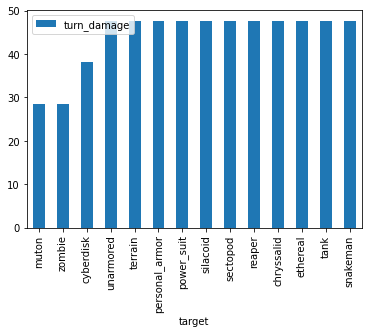

In [31]:
weapon_damages_targets.loc[ "pistol" , : ].plot.bar()

<AxesSubplot:xlabel='target'>

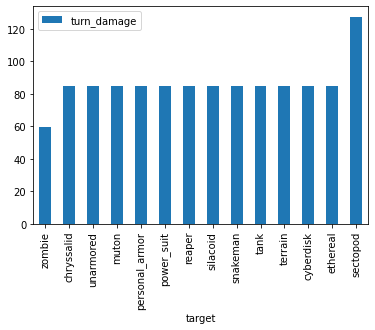

In [32]:
weapon_damages_targets.loc[ "laser_pistol" , : ].plot.bar()

### Target Damage Lists

#### Averages

In [33]:
weapon_damages_averages = weapon_damages_targets.groupby(["weapon"]).mean()
weapon_damages_averages = weapon_damages_averages.sort_values(by=["turn_damage"])
weapon_damages_averages

,turn_damage
weapon,
grenade,21.482426
proximity_grenade,30.075397
alien_grenade,38.668367
pistol,44.261905
rifle,45.964286
high_explosive,47.261338
cannon_turret,55.714286
small_launcher,61.240816
heavy_cannon,61.828571


<AxesSubplot:xlabel='weapon'>

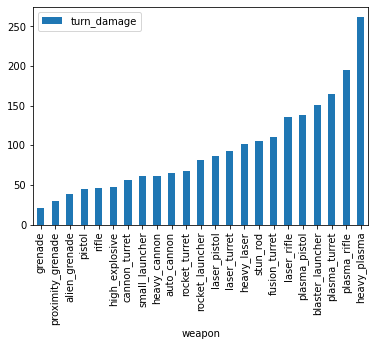

In [34]:
weapon_damages_averages.plot.bar()

#### Terrain

In [35]:
weapon_damages_terrain = weapon_damages_targets.xs("terrain", level="target")
weapon_damages_terrain = weapon_damages_terrain.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

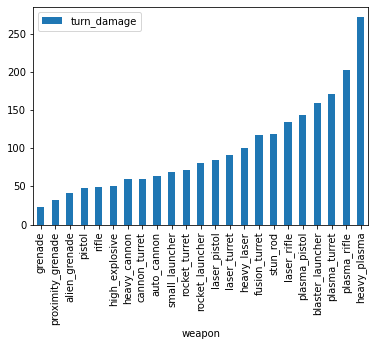

In [36]:
weapon_damages_terrain.plot.bar()

#### Unarmored

In [37]:
weapon_damages_unarmored = weapon_damages_targets.xs("unarmored", level="target")
weapon_damages_unarmored = weapon_damages_unarmored.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

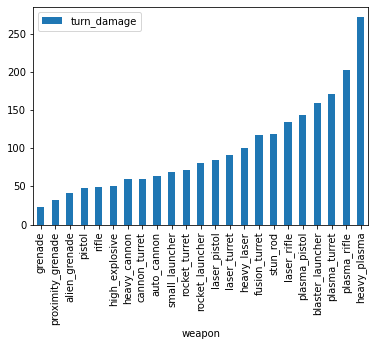

In [38]:
weapon_damages_unarmored.plot.bar()

#### Personal Armor

In [39]:
weapon_damages_armor = weapon_damages_targets.xs("personal_armor", level="target")
weapon_damages_armor = weapon_damages_armor.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

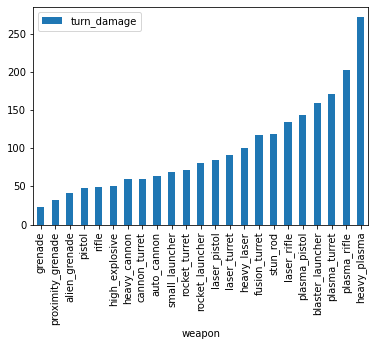

In [40]:
weapon_damages_unarmored.plot.bar()

#### Power Suit

In [41]:
weapon_damages_power_suit = weapon_damages_targets.xs("power_suit", level="target")
weapon_damages_power_suit = weapon_damages_power_suit.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

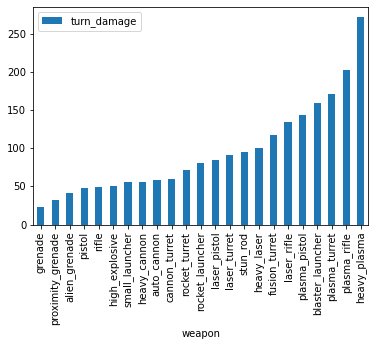

In [42]:
weapon_damages_power_suit.plot.bar()

#### Tank

In [43]:
weapon_damages_tank = weapon_damages_targets.xs("tank", level="target")
weapon_damages_tank = weapon_damages_tank.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

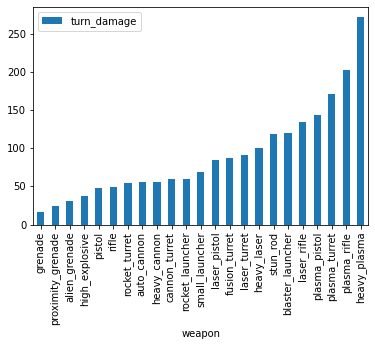

In [44]:
weapon_damages_tank.plot.bar()

#### Snakeman

In [45]:
weapon_damages_snakeman = weapon_damages_targets.xs("snakeman", level="target")
weapon_damages_snakeman = weapon_damages_snakeman.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

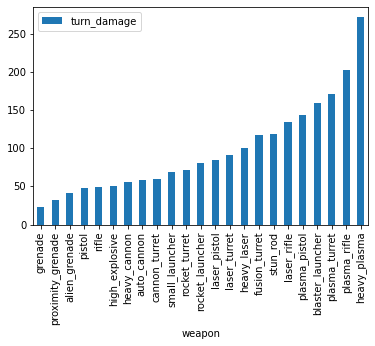

In [46]:
weapon_damages_snakeman.plot.bar()

#### Ethereal

In [47]:
weapon_damages_ethereal = weapon_damages_targets.xs("ethereal", level="target")
weapon_damages_ethereal = weapon_damages_ethereal.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

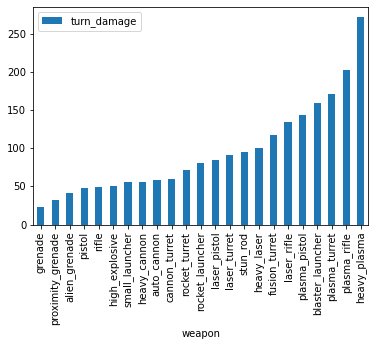

In [48]:
weapon_damages_ethereal.plot.bar()

#### Muton

In [49]:
weapon_damages_muton = weapon_damages_targets.xs("muton", level="target")
weapon_damages_muton = weapon_damages_muton.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

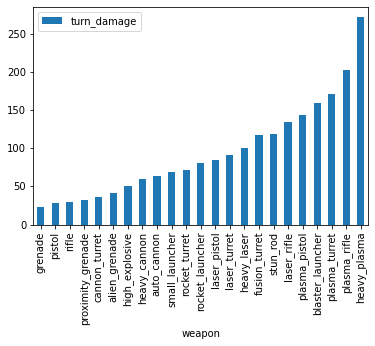

In [50]:
weapon_damages_muton.plot.bar()

#### Silacoid

In [51]:
weapon_damages_silacoid = weapon_damages_targets.xs("silacoid", level="target")
weapon_damages_silacoid = weapon_damages_silacoid.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

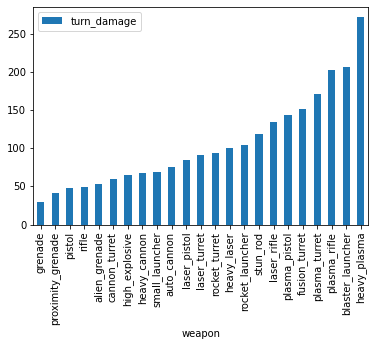

In [52]:
weapon_damages_silacoid.plot.bar()

#### Chryssalid

In [53]:
weapon_damages_chryssalid = weapon_damages_targets.xs("chryssalid", level="target")
weapon_damages_chryssalid = weapon_damages_chryssalid.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

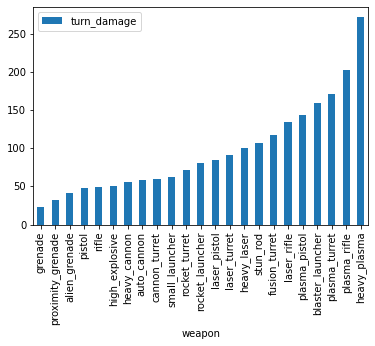

In [54]:
weapon_damages_chryssalid.plot.bar()

#### Reaper

In [55]:
weapon_damages_reaper = weapon_damages_targets.xs("reaper", level="target")
weapon_damages_reaper = weapon_damages_reaper.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

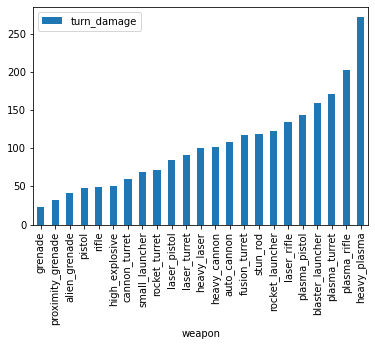

In [56]:
weapon_damages_reaper.plot.bar()

#### Sectopod

In [57]:
weapon_damages_sectopod = weapon_damages_targets.xs("sectopod", level="target")
weapon_damages_sectopod = weapon_damages_sectopod.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

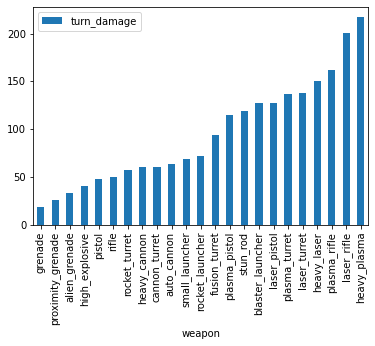

In [58]:
weapon_damages_sectopod.plot.bar()

#### Cyberdisk

In [59]:
weapon_damages_cyberdisk = weapon_damages_targets.xs("cyberdisk", level="target")
weapon_damages_cyberdisk = weapon_damages_cyberdisk.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

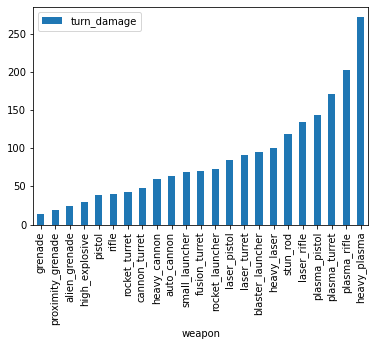

In [60]:
weapon_damages_cyberdisk.plot.bar()

#### Zombie

In [61]:
weapon_damages_zombie = weapon_damages_targets.xs("zombie", level="target")
weapon_damages_zombie = weapon_damages_zombie.sort_values(by=["turn_damage"])

<AxesSubplot:xlabel='weapon'>

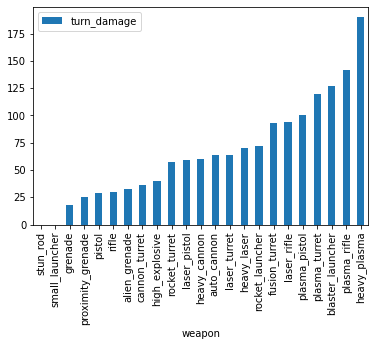

In [62]:
weapon_damages_zombie.plot.bar()